# Chapter 8 : Using convolutions to generalize

### 1. Change our model to use a 5 × 5 kernel with kernel_size=5 passed to the nn.Conv2d constructor.
* What impact does this change have on the number of parameters in the model?
* Does the change improve or degrade overfitting?
* Read https://pytorch.org/docs/stable/nn.html#conv2d.
* Can you describe what kernel_size=(1,3) will do?
* How does the model behave with such a kernel?

In this chapter, we have seen how to make networks as a submodule of the `nn.Module` of Pytorch and how to use convolution and pooling layers to exploit locality, featuring translation invariance and diminishing the size of the feature images. \
Also, we have seen how to create deeper networks and especially how to prevent *vanishing gradient problem* by using tricks like *Batch Normalization* or by using a *skip-connection* for even deeper networks.

We won't use those models here because we are dealing whith small images (3x32x32) and then it is overkill, as the authors say : \
"*All this shouldn’t encourage us to seek depth on a dataset of 32 × 32 images, but it clearly demonstrates how this can be achieved on more challenging datasets like Image- Net. It also provides the key elements for understanding existing implementations for models like ResNet, for instance, in torchvision.*"

In this notebook we will use the model created in the chapter 8 of the book. It was write as an `nn.Module` of Pytorch and it is composed of two hidden layers. \
We recalling it below and re-creating our dataset :

<img style="float: center;" src='data/img_NET.jpg' width="200" height="200" align="center"/>



Note : the models have been already trained, all parameters were saved as a `.pt` file in the `/data` folder.

In [134]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision import datasets

In [4]:
data_path = '/data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
]))

cifar10_val = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
]))

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [22]:
class Net(nn.Module):
    def __init__(self,  n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()
numel_list = [p.numel() for p in model.parameters()] 
print('Total number of parameter : ', sum(numel_list))
print("Number of parameters in each layer : ", numel_list)

Total number of parameter :  38386
Number of parameters in each layer :  [864, 32, 4608, 16, 32768, 32, 64, 2]


In [21]:
### Changing kernel_size
class Net_newkernel(nn.Module):
    def __init__(self,  n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model_kernel5 = Net_newkernel()
numel_list = [p.numel() for p in model_kernel5.parameters()] 
print('Total number of parameter : ', sum(numel_list))
print("Number of parameters in each layer : ", numel_list)

Total number of parameter :  48114
Number of parameters in each layer :  [2400, 32, 12800, 16, 32768, 32, 64, 2]


Without changing the desired output channel size and by selecting a convolution kernel of 5x5, the total number of parameters of our model increases by 25%. 
Note : we had to change the padding to be consistant in terms of output sizes.

In [24]:
import datetime
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            
            outputs = model(imgs) 
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            
def validate(model, train_loader, val_loader):
    accuracy_dict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accuracy_dict[name] = correct / total
    return accuracy_dict

Training on device cpu.


In [20]:
### Saving / Loading parameters
def save_load(save_model, load_model, path, name, model_name):
    if save_model:
        torch.save(model_name.state_dict(), path + name)
        print(f"Parameters of the model {model_name} have been successfully saved")
        return

    if load_model:
        model_name = model_name().to(device=device)
        model_name.load_state_dict(torch.load(path + name, map_location=device))
        print(f"Parameters have been successfully loaded in {model_name}")
        return model_name
    
    if load_model == False and save_model == False:
        raise Exception("You have to specify whether you want to save or load a model.")
    
    if load_model and save_model:
        raise Exception("It can be misleading to save and load the parameters at the same time.")

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [101]:
### Kernel size = 3x3
model_kernel3 = Net().to(device=device)
optimizer33 = optim.SGD(model_kernel3.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer33,
    model = model_kernel3,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-08-27 13:12:33.428234 Epoch 1, Training loss 0.5566195162238589
2021-08-27 13:14:52.495401 Epoch 10, Training loss 0.3142995872315328
2021-08-27 13:17:22.254285 Epoch 20, Training loss 0.26879982953997933
2021-08-27 13:19:42.788088 Epoch 30, Training loss 0.23711505328204222
2021-08-27 13:22:04.542019 Epoch 40, Training loss 0.20966298901920866
2021-08-27 13:24:24.719137 Epoch 50, Training loss 0.18511778068770268
2021-08-27 13:26:45.803298 Epoch 60, Training loss 0.16246780475518505
2021-08-27 13:29:03.531775 Epoch 70, Training loss 0.140480528449177
2021-08-27 13:31:36.007464 Epoch 80, Training loss 0.11949570617003805
2021-08-27 13:34:06.645789 Epoch 90, Training loss 0.1000917593408732
2021-08-27 13:36:28.340460 Epoch 100, Training loss 0.082368084816796


In [6]:
### Kernel size = 5x5
model_kernel5 = Net_newkernel().to(device=device)
optimizer55 = optim.SGD(model_kernel5.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer55,
    model = model_kernel5,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

/Users/thierry/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2021-08-26 08:04:59.188686 Epoch 1, Training loss 0.5278796969325679
2021-08-26 08:08:41.699998 Epoch 10, Training loss 0.3009436071678332
2021-08-26 08:12:47.353033 Epoch 20, Training loss 0.24531514562998608
2021-08-26 08:16:58.558810 Epoch 30, Training loss 0.20092373787407664
2021-08-26 08:21:03.786149 Epoch 40, Training loss 0.16242096444983392
2021-08-26 08:25:29.606520 Epoch 50, Training loss 0.12756616849998
2021-08-26 08:29:37.431415 Epoch 60, Training loss 0.09597909934581465
2021-08-26 08:33:41.640914 Epoch 70, Training loss 0.06892329480522758
2021-08-26 08:38:21.695474 Epoch 80, Training loss 0.04768813655349859
2021-08-26 08:42:38.752955 Epoch 90, Training loss 0.03287433337859193
2021-08-26 08:47:05.050042 Epoch 100, Training loss 0.022978694857376965


In [14]:
_ = validate(model_kernel5, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.89


So the train score in the case of `kernel_size=5` is higher than the one with `kernel_size=3` and the validation accuracies seem to be the same. So, one can deduce that those changes improve overfitting : the train dataset is (almost) perfectly learnt, but it doesn't improve the capacity of the model to generalize through unseen data.

In [95]:
conv33 = nn.Conv2d(3, 32, kernel_size=(3,3), padding=1)
conv13_padding0 = nn.Conv2d(3, 32, kernel_size=(1,3), padding=0)
conv13_padding1 = nn.Conv2d(3, 32, kernel_size=(1,3), padding=1)
conv13_padding01 = nn.Conv2d(3, 32, kernel_size=(1,3), padding=(0,1))
img, _ = cifar2[100]
    
output33 = conv33(img.unsqueeze(0))
output13_padding0 = conv13_padding0(img.unsqueeze(0))
output13_padding1 = conv13_padding1(img.unsqueeze(0))
output13_padding01 = conv13_padding01(img.unsqueeze(0))

print("Output shape with square kernel and padding = 1", output33.shape)
print("Output shape with non-square kernel and padding = 0", output13_padding0.shape)
print("Output shape with non-square kernel and padding = 1", output13_padding1.shape)
print("Output shape with non-square kernel and padding = (0,1)", output13_padding01.shape)

Output shape with square kernel and padding = 1 torch.Size([1, 32, 32, 32])
Output shape with non-square kernel and padding = 0 torch.Size([1, 32, 32, 30])
Output shape with non-square kernel and padding = 1 torch.Size([1, 32, 34, 32])
Output shape with non-square kernel and padding = (0,1) torch.Size([1, 32, 32, 32])


Using a non-square kernel size as `kernel_size=(1,3)` will focus on horizontal detection since there is 3 times more of horizontal than vertical weights. Also, since it's a non-square kernel, we have to set the padding with a tuple `padding = (0,1)` to keep the outputs with the same shape compared to the inputs.

See also : https://stackoverflow.com/questions/59946176/non-squared-convolution-kernel-size

In [76]:
model_kernel5

Net_newkernel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [96]:
### Changing kernel_size
class Net_newkernel13(nn.Module):
    def __init__(self,  n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=(1,3), padding=(0,1))
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=(1,3), padding=(0,1))
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [97]:
model_kernel13 = Net_newkernel13().to(device=device)
optimizer13 = optim.SGD(model_kernel13.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer13,
    model = model_kernel13,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-08-27 01:08:38.589325 Epoch 1, Training loss 0.5460081045414992
2021-08-27 01:10:14.091815 Epoch 10, Training loss 0.34842085249864374
2021-08-27 01:11:57.321762 Epoch 20, Training loss 0.3048952476234193
2021-08-27 01:13:40.956657 Epoch 30, Training loss 0.2738129356104857
2021-08-27 01:15:33.337801 Epoch 40, Training loss 0.24778122777581973
2021-08-27 01:17:20.499185 Epoch 50, Training loss 0.22464247394329423
2021-08-27 01:19:05.138778 Epoch 60, Training loss 0.20445078108341072
2021-08-27 01:20:55.802694 Epoch 70, Training loss 0.18624177722224763
2021-08-27 01:22:38.342078 Epoch 80, Training loss 0.16885942699992731
2021-08-27 01:24:07.769352 Epoch 90, Training loss 0.15164617847674972
2021-08-27 01:25:34.456400 Epoch 100, Training loss 0.13446136367074243


In [99]:
validate(model_kernel13, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


{'train': 0.9427, 'val': 0.89}

Well we can see that the train score decreased while the validation score is still the same. Hence, the model is less overfitting and keep the same capacity to generelize unseen data. \
By changing the size of the kernel and focus on one direction, it seems that we made the model less constrain and then, reduced overfitting.

Also, I don't really know if it's relevent, but we can look at the running time on the same machine with the same parameters but different kernel sizes (`kernel_size = 5` and `kernel_size = (1,3)`). Using the non-square kernel appears to reduce the running time by 40%

### 2. Can you find an image that contains neither a bird nor an airplane, but that the model claims has one or the other with more than 95% confidence?

* Can you manually edit a neutral image to make it more airplane-like?
* Can you manually edit an airplane image to trick the model into reporting a bird?
* Do these tasks get easier with a network with less capacity? More capacity?

In [7]:
model = save_load(False, True, '', 'databirds_vs_airplanes_kernel=3.pt', Net)

Parameters have been successfully loaded in Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


Let's construct a `cifar3` variable which is cifar10 without 'airplane' and 'bird' images. Also, since we're interested in probabilities, we'll call the `nn.Softmax` function to convert the output into those.

In [27]:
import random as rd
cifar3 = [(img, label) for img, label in cifar10 if label not in [0, 2]]
softmax = nn.Softmax(dim=1)

class_names_long = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

So, we are looking for an image which is neither an airplane or a bird, but that the model claims has one or the other with more than 95% confidence. Because we don't really know where this image is, we'll proceede by random search to avoid computational efforts.

In [86]:
output_prob = torch.tensor(0.)
count = 0
while torch.max(output_prob).item() <= 0.95:
    img, label = rd.choice(cifar3)
    output = model(img.unsqueeze(0))
    output_prob = softmax(output)
    count += 1
    if count > len(cifar3):
        break
    
if torch.max(output_prob).item() == output_prob[0][0].item():
    prediction = "airplane"
elif torch.max(output_prob).item() == output_prob[0][1].item():
    prediction = "bird"

print(f"{torch.max(output_prob).item():.4f}")
print(f"The current model found that a '{class_names_long[label]}' is actually a '{prediction}' \
with more than 95% of certainty.")

0.9847
The current model found that a 'horse' is actually a 'airplane' with more than 95% of certainty.


The three last questions are a bit odd to me. So starting here, I will use my common sense and try some things that could lead to the answers.

We are looking for a neutral image. So maybe an image that is neither an airplane nor a bird for sure. So, since our model is only capable to identify airplane or bird, we are looking for an image that our model claims to be one or the other with a probability around 50%.

In [217]:
output_prob = torch.tensor([[99., 99.]])
count = 0

while torch.max(output_prob).item() >= 0.55:
    img, label = rd.choice(cifar3)
    output = model(img.unsqueeze(0))
    output_prob = softmax(output)
    count += 1
    if count > len(cifar3):
        print("Break time")
        break
    
if torch.max(output_prob).item() == output_prob[0][0].item():
    prediction = "airplane"
elif torch.max(output_prob).item() == output_prob[0][1].item():
    prediction = "bird"

print(f"The current model found that a '{class_names_long[label]}' is actually a '{prediction}' \
with a probability of {torch.max(output_prob).item():.4f}.")

The current model found that a 'frog' is actually a 'bird' with a probability of 0.5053.


We're going to apply some transformation and see if anything is changing regarding the model predictions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.0025, 0.9975]], grad_fn=<SoftmaxBackward>)


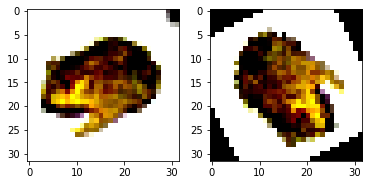

In [219]:
import torchvision.transforms.functional as FT
img_w = torch.clone(img)
img_wr = FT.rotate(img_w, 115)

output = model(img_wr.unsqueeze(0))
output_prob = softmax(output)
print(output_prob)

plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img_wr.permute(1,2,0))

By rotating the input image by 115 degres, it appears to be more "airplane-like" to the model with a probabilty of 99.75%.

Let's now find an airplane image and try to trick the model.

In [224]:
output_prob = torch.tensor([[0., 0.]])
count = 0

while torch.max(output_prob).item() <= 0.98:
    img, label = rd.choice(cifar2)
    output = model(img.unsqueeze(0))
    output_prob = softmax(output)
    count += 1
    if count > len(cifar2):
        print("Break time")
        break
    
if torch.max(output_prob).item() == output_prob[0][0].item():
    prediction = "airplane"
elif torch.max(output_prob).item() == output_prob[0][1].item():
    prediction = "bird"

print(f"The current model found that a '{class_names[label]}' is actually a '{prediction}' \
with a probability of {torch.max(output_prob).item():.4f}.")

The current model found that a 'airplane' is actually a 'airplane' with a probability of 0.9996.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.5058, 0.4942]], grad_fn=<SoftmaxBackward>)


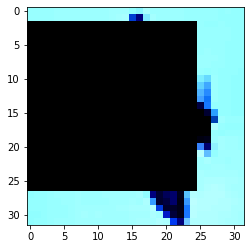

In [265]:
img_airplane_bird = torch.clone(img)
transformer = transforms.RandomErasing(p=1, scale=(0., 1), ratio=(1, 1), value=0, inplace=False)
img_airplane_bird = transformer(img_airplane_bird)

output = model(img_airplane_bird.unsqueeze(0))
output_prob = softmax(output)
print(output_prob)
plt.imshow(img_airplane_bird.permute(1,2,0));

Against all wishes, it's actually very complicated to trick this simple model. Even by erasing a large part of the image, it still convinced that it is a plane. Only with luck, when the crop is in a particular area, we reach 50% of probability. At the contrary, if we rotate the image like the one before, there is a switch with a 120 degres rotation. 

Does that mean that our model is not rotation invariant and that it doesn't keep tracks of the shapes when they are rotate ?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.1668, 0.8332]], grad_fn=<SoftmaxBackward>)


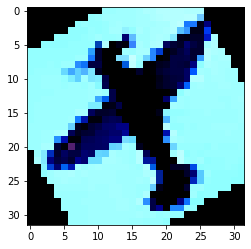

In [271]:
img_airplane_bird2 = torch.clone(img)
img_wr = FT.rotate(img_airplane_bird2, 120)

output = model(img_wr.unsqueeze(0))
output_prob = softmax(output)
print(output_prob)
plt.imshow(img_wr.permute(1,2,0));

* Do these tasks get easier with a network with less capacity? More capacity? \
I do not know how to conclude on this question... Maybe one has to think about overfitting and underfitting.
To be continued... 